### КЕЙС

Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns  
import plotly.express as px

### Исходные данные

In [115]:
#импорт данных

df_train = pd.read_csv('data/hotels_train.csv') 
df_test = pd.read_csv('data/hotels_test.csv') 

In [116]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [117]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [118]:
#поиск пропусков в данных

null_data = df_train.isnull().sum()

print(f'\nСтолбцы с явными пропусками данных:\n{null_data[null_data > 0]}')


Столбцы с явными пропусками данных:
lat    2448
lng    2448
dtype: int64


In [119]:
#заполнение пропусокв

df_train = df_train.fillna(0)

### Оценим влияние расположения отеля на отзыв. Возможно в какой-либо стране отели оценивают по разному.

In [120]:
addresses = pd.Series(df_train['hotel_address'].unique())

print('\nРассмотрим структуру строк с данными адреса:')
display(addresses)


Рассмотрим структуру строк с данными адреса:


0       Stratton Street Mayfair Westminster Borough Lo...
1       130 134 Southampton Row Camden London WC1B 5AF...
2        151 bis Rue de Rennes 6th arr 75006 Paris France
3       216 Avenue Jean Jaures 19th arr 75019 Paris Fr...
4               Molenwerf 1 1014 AG Amsterdam Netherlands
                              ...                        
1488      Viriotgasse 5 09 Alsergrund 1090 Vienna Austria
1489             8 rue d Anjou 8th arr 75008 Paris France
1490    Prinsengracht 717 Amsterdam City Center 1017 J...
1491    43 Rue De l Abb Gr goire 6th arr 75006 Paris F...
1492    Johann Staud Stra e 32 16 Ottakring 1160 Vienn...
Length: 1493, dtype: object

In [121]:
#выбираем страну из адреса отеля
df_train['hotel_country'] = df_train['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

### Визуализируем зависимость оценки от страны

Text(0.5, 1.0, 'Зависимость средней оценки\nот страны отеля')

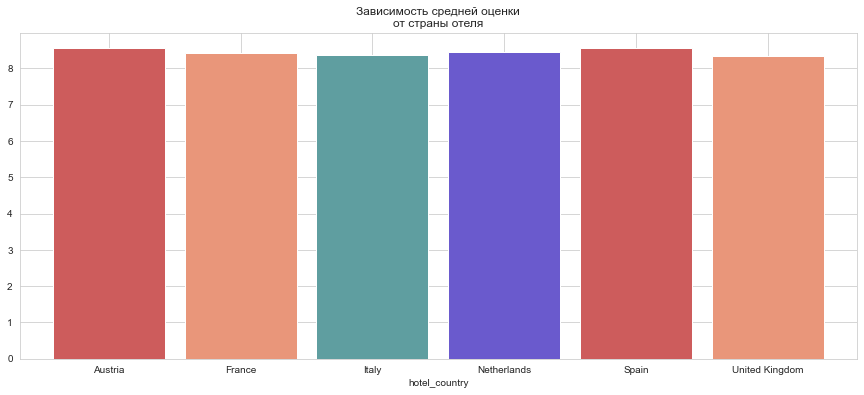

In [122]:
pivot_country_score = df_train.groupby(['hotel_country'])['reviewer_score'].mean()

fig1, ax1 = plt.subplots(figsize=(15, 6))
sns.set_style('whitegrid')
district_type_plot = pivot_country_score.plot(
    ax=ax1, 
    kind='bar', 
    width=0.85, 
    color=['indianred', 'darksalmon', 'cadetblue', 'slateblue'],
    rot=0)

ax1.set_title('Зависимость средней оценки\nот страны отеля')

Средний бал во всех странах примерно одинаковый, можно сделать вывод, что страна, где находится отель не влияет на средний бал.

### Рассмотрим временной период опубликования оценок

In [123]:
#изменим формат даты, оставим месяц опубликования
df_train['month'] = pd.to_datetime(df_train['review_date']).dt.month

In [124]:
# Готовим данные для графика в виде сводной таблицы

data = df_train.groupby('month')['reviewer_score'].agg(count='count').reset_index().sort_values(by='month')
data.head()

,month,count
0,1,31512
1,2,28735
2,3,30901
3,4,32213
4,5,34684


In [125]:
# Фильтруем и готовим данные по влиянию времени на оценку

data1 = df_train[df_train['reviewer_score'] >=8].groupby('month')['reviewer_score'] \
             .agg(count='count').reset_index().sort_values(by='month')

data2 = df_train[df_train['reviewer_score'] <8].groupby('month')['reviewer_score'] \
             .agg(count='count').reset_index().sort_values(by='month')
             
data1.head()

,month,count
0,1,21176
1,2,19673
2,3,20742
3,4,21268
4,5,22571


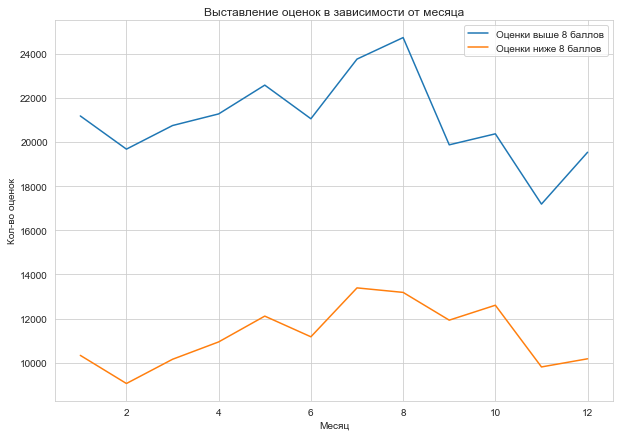

In [126]:
# Строим линейный график с отфильтрованными данными

plt.figure(figsize=(10, 7))

plt.plot(data1['month'], data1['count'])
plt.plot(data2['month'], data2['count'])

plt.title('Выставление оценок в зависимости от месяца')
plt.xlabel('Месяц')
plt.ylabel('Кол-во оценок')
plt.legend(['Оценки выше 8 баллов', 'Оценки ниже 8 баллов'])

plt.show()

#### Здесь очевидный вывод, что с 6 по 8 месяц - сезон отпусков и путешествий, соответственно и увеличение оценок.
Возможно данный параметр имеет смысл учитывать при обучении модели

### Рассмотрим Теги для оценки свзя между оценкой и поставленными тегами

In [127]:
# поиск регулярных выражений

import re

def re_func(num_tags):
    found = re.findall("'[^\'](.+?)[^\']'", num_tags)
    return found


df_train['tags_n'] = df_train['tags'].apply(re_func)
df_train = df_train.explode('tags_n')

df_train['tags_n'].unique()
df_train['tags_n'].value_counts()

Leisure trip                                                   313593
Submitted from a mobile device                                 230778
Couple                                                         189212
Stayed 1 night                                                 145373
Stayed 2 nights                                                100263
                                                                ...  
Deluxe Family Room with 1 Double and 2 Single Beds                  1
One Bedroom Executive Suite with Lounge Access                      1
Oscar Wilde Room                                                    1
Twin Junior Suite City View with Access to Executive Lounge         1
Executive Premium Queen Room with Sofa Bed                          1
Name: tags_n, Length: 2368, dtype: int64

In [128]:
#самые редкие теги у отзывов 
df = df_train.pivot_table('tags_n', index='reviewer_score', columns='hotel_country', aggfunc='min')
display(df)

hotel_country,Austria,France,Italy,Netherlands,Spain,United Kingdom
reviewer_score,,,,,,
2.5,2 rooms,2 Connecting Rooms 4 people,2 rooms,2 rooms,2 rooms,2 rooms
2.9,Business trip,2 rooms,2 rooms,2 rooms,2 rooms,2 rooms
3.0,NaN,2 Adjacent Non Communicating Rooms,Comfort Quadruple Room,Business trip,NaN,Business trip
3.1,NaN,NaN,NaN,Business trip,NaN,Business trip
3.3,2 rooms,2 Connecting Deluxe Rooms with VIP Service for...,2 rooms,2 rooms,2 rooms,2 rooms
3.5,2 rooms,Business trip,Business trip,Business trip,Couple,Basic Double Room
3.8,2 rooms,2 rooms,2 rooms,2 rooms,2 rooms,2 rooms
4.0,2 rooms,Business trip,Business trip,Couple,Business trip,2 rooms
4.2,2 rooms,2 Connecting Deluxe Rooms with VIP Service for...,1 King Bed Guest Room,2 rooms,2 rooms,2 rooms


In [129]:
#визуализируем полученную матрицу
px.scatter(df, log_x=True, size_max=60)


In [130]:
#самые частые теги
df = df_train.pivot_table('tags_n', index='reviewer_score', columns='hotel_country', aggfunc='max')
display(df)

hotel_country,Austria,France,Italy,Netherlands,Spain,United Kingdom
reviewer_score,,,,,,
2.5,With a pet,With a pet,With a pet,Twin Room,Wonderful Double or Twin Room,Wonderful Room
2.9,penta Standard Room,With a pet,With a pet,With a pet,Wonderful Double or Twin Room,Wonderful Room
3.0,NaN,Superior Room with 2 Double Beds,Superior Twin Room with Two Double Beds,Submitted from a mobile device,NaN,Twin Room
3.1,NaN,NaN,NaN,Stayed 14 nights,NaN,Superior Double Room
3.3,Weekend Offer Standard Studio,With a pet,With a pet,With a pet,Wonderful Double or Twin Room,With a pet
3.5,Superior Double Room,Superior Double or Twin Room,Superior Double or Twin Room,Submitted from a mobile device,Submitted from a mobile device,With a pet
3.8,penta Standard Room,With a pet,With a pet,Wonderful Exchange King,Wonderful Double or Twin Room,Wonderful Room
4.0,Superior Double Room,Superior Twin Room,Superior Double or Twin Room,Superior Double Twin Room with Free Parking,Submitted from a mobile device,Twin Room
4.2,X Ordinary Room,Wonderful Double Room,With a pet,Wonderful Exchange King,Wonderful Double or Twin Room,Wonderful Room


In [131]:
#визуализируем полученную матрицу
px.scatter(df, log_x=True, size_max=60)

#### Можно отметить, что самые редкие теги и самые популярные теги встречаются у отелей, которые получили как минимальную, так и максимальную оценку

In [132]:
#расмотрим связь количества тегов и оценку
df = df_train.pivot_table('tags_n', index='reviewer_score', columns='hotel_country', aggfunc='count')
display(df)

hotel_country,Austria,France,Italy,Netherlands,Spain,United Kingdom
reviewer_score,,,,,,
2.5,434.0,1047.0,708.0,875.0,693.0,3713.0
2.9,276.0,866.0,505.0,634.0,473.0,2839.0
3.0,NaN,13.0,17.0,18.0,NaN,63.0
3.1,NaN,NaN,NaN,4.0,NaN,21.0
3.3,508.0,1181.0,672.0,954.0,992.0,5171.0
3.5,18.0,28.0,37.0,28.0,19.0,152.0
3.8,758.0,1803.0,1012.0,1367.0,1221.0,7619.0
4.0,12.0,37.0,13.0,17.0,5.0,212.0
4.2,1048.0,2144.0,1182.0,1817.0,1677.0,9596.0


In [133]:
#визуализируем полученную матрицу
px.scatter(df, log_x=True, size_max=60)


#### Можно заметить, что с увеличением оценки увеличивается и количество тегов.
Это стоит учесть при прогнозировании оценки отелей

In [207]:
df_train = pd.read_csv('data/hotels_train.csv') 

In [208]:
#создадим колонку с количеством тегов
def word_count(string):

    return(len(string.strip().split(" ")))

df_train['tags_c'] = df_train['tags'].apply(word_count)

In [ ]:
df_train['tags_c'].describe()

Можно сказать, что значения (количество тегов) меньше 18 являются выбросами

In [ ]:
df_train.loc[(df_train['tags_c'] <= 18), 'tags_c'] = df_train['tags_c'].mean()
df_train['tags_c'].describe()

In [212]:
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,tags_c
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,23.000000
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,22.252317
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,26.000000
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540,21.000000
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060,19.000000


In [203]:
df = df_train.pivot_table('tags_c', index='reviewer_score', aggfunc='count')
df.describe()


,tags_c
count,37.000000
mean,10454.135135
std,18751.535340
min,6.000000
25%,97.000000
50%,1211.000000
75%,11244.000000
max,86803.000000


In [204]:
#визуализируем полученную матрицу
px.scatter(df, log_x=True, size_max=60)

#### Можно сказать, что значения на графике менее 5000 являются выбросами